In [1]:
import os
import pandas as pd
import numpy as np
from importlib import reload
from PATH import data_path
from importlib import reload


from matplotlib import pyplot as plt

from sklearn import preprocessing,decomposition
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split

import utils
import Model
reload(utils)
reload(Model)
from utils import *
from Model import *

## Loading data

In [13]:
# loading data by function in utils
label = read_label(data_path)
data_DF = read_data_DF(data_path)

In [213]:
merged_DF=data_DF.merge(label,left_index=True,right_on=['sample'])

In [214]:
merged_DF.index = range(merged_DF.shape[0])

In [1]:
DF=merged_DF[merged_DF.status=='Negative'].iloc[:,0:-2].append(
    merged_DF[merged_DF.status=='Positive'].iloc[:,0:-2]
)
data = DF.values

NameError: name 'merged_DF' is not defined

## Scale data first

In [ ]:
#### scale by gene : function: `scaling_by_gene`
data_erbb2 = scaling_by_gene(data,'ERBB2',column=data_DF.columns)

#### scale with clean data
data_norm = preprocessing.scale(data)

## PCA decomposition

In [208]:
PCA = decomposition.PCA(n_components=0.9)

## split train test

In [28]:
y=np.array([0]*463 + [1]*(611 - 463))

datas = [data,data_log,data_norm,data_erbb2]
#datas += [PCA.fit_transform(data) for data in datas]

## try LDA

In [747]:
set_ls = spliting_datas_by_the_same(datas,y,True,**{'idx':y})

------------------------------------
Data Set    Raio of positive Sample
------------------------------------
 whole	 | 	 0.24222585924713586
 train	 | 	 0.2630208333333333
 val	 | 	 0.23255813953488372
 test	 | 	 0.20108695652173914
------------------------------------


In [872]:
LDA_ls=[single_model(DataSet=Set,model=LDA,with_test=True,**{}) for Set in set_ls]

In [874]:
LDA_ls[0]

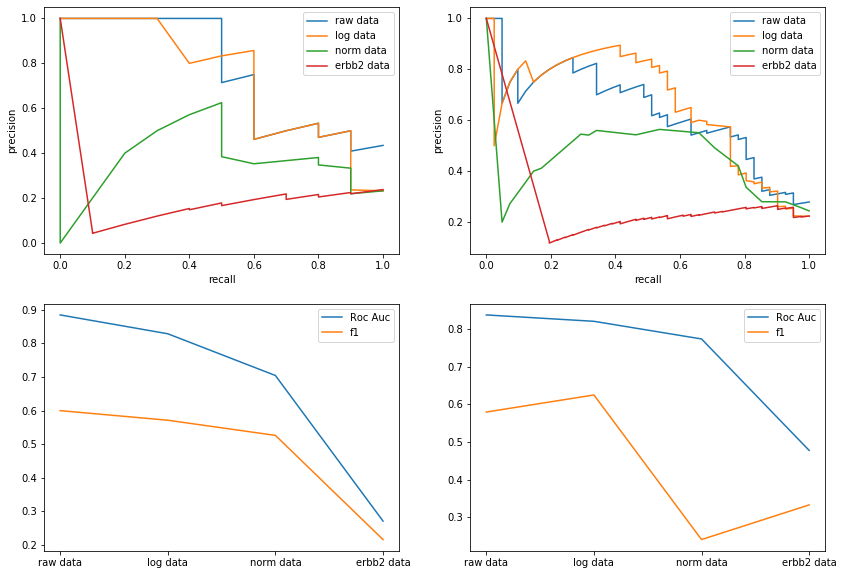

In [875]:
plt.figure(figsize=(14,10))
count = 0
for test in range(2):
    count += 1
    plt.subplot(2,2,count)
    plot_PR_curve(LDA_ls,test=test,label=['raw data','log data','norm data','erbb2 data'])
for test in range(2):
    count += 1
    plt.subplot(2,2,count)
    plot_auc_f1(LDA_ls,test=test,**xtiscks)

In [726]:
xtiscks = {'ticks':range(0,4),
           'labels':['raw data','log data','norm data','erbb2 data']}
#                     'raw_PCA','log_PCA','norm_PCA','erbb2_PCA']}

In [622]:
joblib.dump(LDA_ls,'Excellent.LDAList')

['Excellent.LDAList']

In [271]:
precision, recall, thresholds=precision_recall_curve(y_true=set_ls[1][-1],
                                                     probas_pred=LDA_ls[1].predict_proba(set_ls[1][2])[:,1])

## try SVM

In [548]:
SV_ls = [[model_ls(DataSet=Set,model=SVC,with_test=True,
                   **{'C':i,'probability':True}) for i in [0.01,0.1,1,5,10,50]] 
         for Set in set_ls[:4]]

In [487]:
SV_ls = [[SVC_model(Set,with_test=True,**{'C':i}) for i in [0.1,1,5,10,50,100]] for Set in set_ls[:2]]

#joblib.dump(SV_ls,'result/data_4pre_rbf.SVCList')

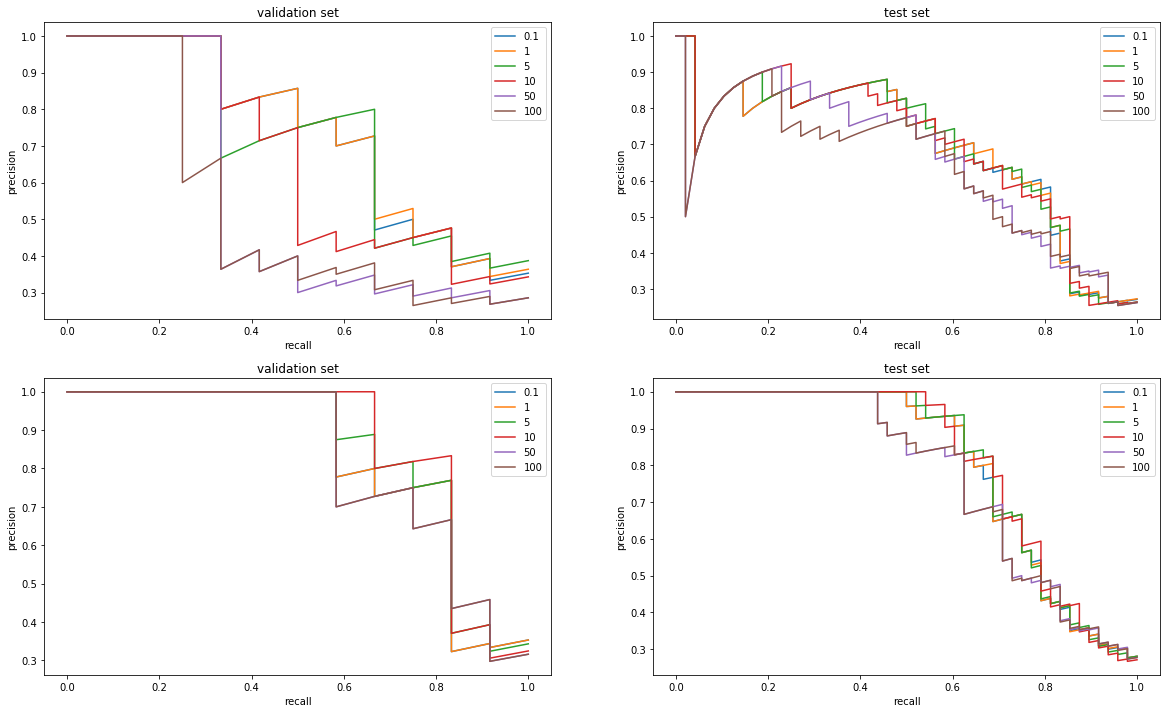

In [498]:
plt.figure(figsize=(20,12))
count = 0
for i in range(2):
    for test in range(2):
        count += 1
        plt.subplot(2,2,count)
        plot_PR_curve(SV_ls[i],test=test,label=[0.1,1,5,10,50,100])
        plt.title('{} set'.format(['validation','test'][test]))

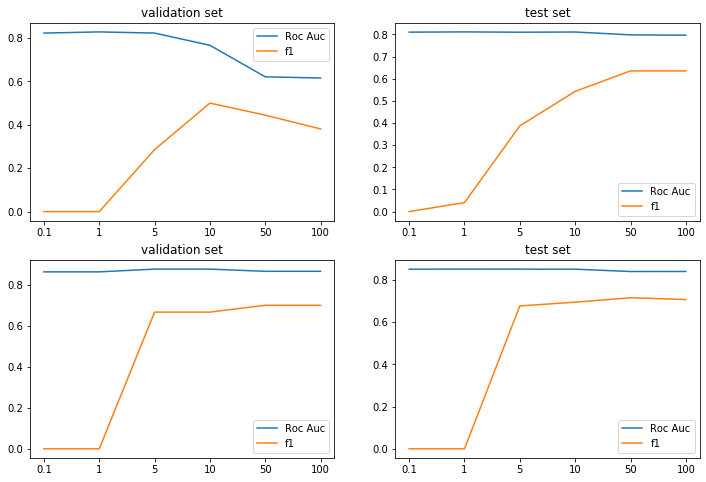

In [541]:
plt.figure(figsize=(12,8))
count = 0
for i in range(2):
    for test in range(2):
        count += 1
        plt.subplot(2,2,count)
        plot_auc_f1(SV_ls[i],test=test)
        plt.xticks(range(6),[0.1,1,5,10,50,100])
        plt.title('{} set'.format(['validation','test'][test]))

## try logistic regression

In [502]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RF

In [654]:
LR_ls = [single_model(model=LR,DataSet=Set,with_test=True,**LR_arg) for Set in set_ls[:4]]

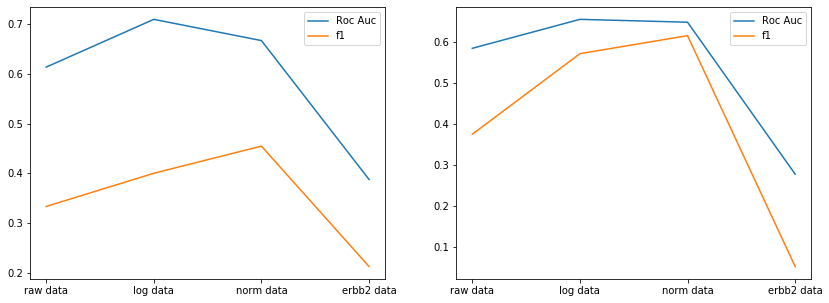

In [656]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plot_auc_f1(LR_ls,test=0,
            **{'ticks':range(0,4),
               'labels':['raw data','log data','norm data','erbb2 data']})
plt.subplot(1,2,2)
plot_auc_f1(LR_ls,test=1,
            **{'ticks':range(0,4),
               'labels':['raw data','log data','norm data','erbb2 data']})

In [659]:
RF_arg={'n_estimators':10,'criterion':'gini','max_depth':None,'min_samples_split':2,'min_samples_leaf':1,
'min_weight_fraction_leaf':0.0,'max_features':'auto','max_leaf_nodes':None,'min_impurity_decrease':0.0,
'min_impurity_split':None,'bootstrap':True,'oob_score':False,'n_jobs':1,'random_state':None,'verbose':0,
'warm_start':False,'class_weight':None}

## RANDOM FOREST

In [660]:
from sklearn.ensemble import RandomForestClassifier as RF

In [767]:
set_ls = spliting_datas_by_the_same(datas,y,True,**{'idx':y})

------------------------------------
Data Set    Raio of positive Sample
------------------------------------
 whole	 | 	 0.24222585924713586
 train	 | 	 0.2526041666666667
 val	 | 	 0.23255813953488372
 test	 | 	 0.22282608695652173
------------------------------------


In [768]:
RF_ls = [single_model(model=RF,DataSet=Set,with_test=True,**RF_arg) for Set in set_ls[:4]]

In [769]:
#val_metrics = []
#test_metrics = []

local_val = []
local_test = []
for i in range(len(RF_ls)):
    RF_ls[i].get_metrics(test=0)
    val_metrics.append([RF_ls[i].f1,RF_ls[i].auc])
    local_val.append(RF_ls[i].f1+RF_ls[i].auc)
    
    RF_ls[i].get_metrics(test=1)
    test_metrics.append([RF_ls[i].f1,RF_ls[i].auc])
    local_test.append([RF_ls[i].f1,RF_ls[i].auc])

In [866]:
max_id = np.argmax(local_val)

In [867]:
max_id

3

In [765]:
if (np.sum(local_test[max_id]) >= np.max(np.sum(test_metrics,axis=1))) & (local_test[max_id][0] > 0.6):
    joblib.dump(set_ls,'result/RF_result/the_{}_setls.SetList'.format(repeat))
    joblib.dump(RF_ls[max_id],'result/RF_result/the_{}_RF.Model'.format(repeat))

[0.6896551724137931, 0.7924528301886793]

In [796]:
val=val_metrics[-4:]

In [797]:
test=test_metrics[-4:]

In [881]:
test_val = []

In [883]:
for i in range(1,5):
    test_val += val_metrics[:5]

In [888]:
ttt = np.array(test_val[:5])

In [945]:
vvv = ttt

In [1014]:
SV_ls = [ [single_model(DataSet=Set,model=SVC,with_test=True,**{'C':i,'probability':True}) for i in [0.1,1,10,100]]  for Set in set_ls]

In [1028]:
val_metrics = []
test_metrics = []
local_val = []
local_test = []
    
for Set_i in range(len(set_ls)):

    model_ls = SV_ls[Set_i]
    data_label = ['raw','norm','log','erbb2']

    for i in range(len(model_ls)):
        model_ls[i].get_metrics(test=0)
        val_metrics.append([model_ls[i].f1,model_ls[i].auc])
        local_val.append(model_ls[i].f1+model_ls[i].auc)

        model_ls[i].get_metrics(test=1)
        test_metrics.append([model_ls[i].f1,model_ls[i].auc])
        local_test.append([model_ls[i].f1,model_ls[i].auc])
        
    vobosing_SVM(val_metrics[-4:],local_test,data_label)

  DATA : ['raw', 'norm', 'log', 'erbb2']
----------------------------------------------------------------------------------------
 C 	 | 0.01 	|   0.1  	|    1  	|   10  	|   1001 	
----------------------------------------------------------------------------------------
v: f1 	 | 0.00000 	|     0 	| 0.77778 	| 0.72000 	| 	
v: auc 	 | 0.92424 	|     1 	| 0.94848 	| 0.87273 	| 	
----------------------------------------------------------------------------------------
t: f1 	 | 0.00000 	|     0 	| 0.58462 	| 0.46154 	| 	
t: auc 	 | 0.81153 	|     1 	| 0.80113 	| 0.75593 	| 	
----------------------------------------------------------------------------------------
  DATA : ['raw', 'norm', 'log', 'erbb2']
----------------------------------------------------------------------------------------
 C 	 | 0.01 	|   0.1  	|    1  	|   10  	|   1001 	
----------------------------------------------------------------------------------------
v: f1 	 | 0.00000 	|     0 	| 0.77778 	| 0.63158 	| 	
v: auc 	

In [1027]:
val_metrics

[[0.0, 0.9242424242424243]]

In [1026]:
val_metrics[-4:]

[[0.0, 0.9242424242424243]]

In [1024]:
vobosing_SVM(val_metrics[-4:],local_test,'log')

  DATA : log
----------------------------------------------------------------------------------------
 C 	 | 0.01 	|   0.1  	|    1  	|   10  	|   1001 	
----------------------------------------------------------------------------------------
v: f1 	 | 0.00000 	|     0 	| 0.75000 	| 0.66667 	| 	
v: auc 	 | 0.63636 	|     1 	| 0.83939 	| 0.81212 	| 	
----------------------------------------------------------------------------------------
t: f1 	 | 0.00000 	|     0 	| 0.58462 	| 0.46154 	| 	
t: auc 	 | 0.81153 	|     1 	| 0.80113 	| 0.75593 	| 	
----------------------------------------------------------------------------------------


In [1021]:
def vobosing_SVM(vvv,ttt,data):
    vvv = np.array(vvv)
    ttt = np.array(ttt)
    print('  DATA : %s'%data)
    print('----'*22)
    print(' C \t | 0.01 \t|   0.1  \t|    1  \t|   10  \t|   1001 \t')
    print('----'*22)
    for i in range(2):
        print('%s \t | %.5f \t| %5.f \t| %.5f \t| %.5f \t| \t'%('v:'+[' f1',' auc'][i],vvv[0,i],vvv[1,i],vvv[2,i],vvv[3,i]))
    print('----'*22)
    for i in range(2):
        print('%s \t | %.5f \t| %5.f \t| %.5f \t| %.5f \t| \t'%('t:'+[' f1',' auc'][i],ttt[0,i],ttt[1,i],ttt[2,i],ttt[3,i]))
    print('----'*22)

In [1011]:
vobosing_SVM(vvv,ttt,'log')

  DATA : log
----------------------------------------------------------------------------------------
 C 	 | 0.01 	|   0.1  	|    1  	|   10  	|   1001 	
----------------------------------------------------------------------------------------
v: f1 	 | 0.22222 	|     0 	| 0.25000 	| 0.60000 	|  0.75000 	
v: auc 	 | 0.57937 	|     1 	| 0.69643 	| 0.75794 	|  0.89697 	
----------------------------------------------------------------------------------------
t: f1 	 | 0.22222 	|     0 	| 0.25000 	| 0.60000 	|  0.75000 	
t: auc 	 | 0.57937 	|     1 	| 0.69643 	| 0.75794 	|  0.89697 	
----------------------------------------------------------------------------------------


In [854]:
import argparse

In [860]:
parser = argparse.ArgumentParser()
parser.add_argument('--model',type=str,help='the model to use : can choose from : LDA, LR, RF, SVC')
parser.add_argument('--repeat',default=1000,type=int,help='times of spliting and training')
args = parser.parse_args()

In [864]:
model = {'LDA':LDA, 'LR':LR,'RF':RF, 'SVC':SVC}[args.model]

In [1030]:
import time

In [1035]:
time.time()

1589275645.9923704

In [868]:
model_arg = {'LDA':None, 'LR':LR_arg,'RF':RF_arg, 'SVC':None}[args.model]